# DCGAN implemented on MxNet Gluon

In [13]:
from __future__ import print_function
import os
import mxnet as mx
import random
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
import matplotlib.pyplot as plt

## Initialize the hyper parameters

In [14]:
class Options:
    def __init__(self):
        self.dataset = 'celebA' # cifar10 , celebA
        #self.dataroot = '/EBS100G/GAN_resutls/lfw/lfw-deepfunneled' # path to dataset
        self.dataroot = './data' # path to dataset
        self.batchSize = 64 # input batch size
        self.imageSize = 64 # the height / width of the input image to network'
        self.nz =100 # size of the latent z vector
        self.ngf = 64
        self.ndf = 64 
        self.nc = 3 #numb color
        self.niter =125 # number of epochs to train for
        self.lr = 0.0001 # learning rate, default=0.0002
        self.beta1 = 0.5 # beta1 for adam
        self.beta2 = 0.999 # beta2 for adam
        self.ctx = mx.gpu() #  enables gpu
        self.ngpu = 1 # number of GPUs to use
#         self.G_net = '' # path to netG (to continue training)
#         self.D_net = '' #help="path to netD (to continue training)")
        self.outf = './data/' # help='folder to output images and model checkpoints')
        self.manualSeed = random.randint(1, 10000) # manual seed 
        self.clip_gradient = 10.0

opt = Options()
try:
    os.makedirs(opt.outf)
except OSError:
    pass
mx.random.seed(opt.manualSeed)



## Load the target data

In [15]:
def transformer(data, label):
    data = mx.image.imresize(data, opt.imageSize, opt.imageSize)
    data = mx.nd.transpose(data, (2,0,1))
    data = data.astype(np.float32)/128.0-1.0 
    return data, label

## Creat a data iterator

In [16]:
if opt.dataset == 'cifar10':
    train_data = gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(opt.dataroot, train=True, transform=transformer),
        batch_size= opt.batchSize, shuffle=True, last_batch='discard')

    test_data = gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(opt.dataroot, train=False, transform=transformer),
        batch_size=opt.batchSize, shuffle=False, last_batch='discard')
    
if opt.dataset == 'celebA':
    opt.dataroot = '%s/celebA/Trainset' % (opt.dataroot)
    train_data = gluon.data.DataLoader(
        gluon.data.vision.ImageFolderDataset(opt.dataroot,transform=transformer),
        batch_size= opt.batchSize, shuffle=True, last_batch='discard')

    test_data = gluon.data.DataLoader(
        gluon.data.vision.ImageFolderDataset(opt.dataroot, transform=transformer),
        batch_size=opt.batchSize, shuffle=False, last_batch='discard')
    


## Creat the Generator and Discriminator networks

In [17]:
G_Net = gluon.nn.Sequential()
with G_Net.name_scope():
    #first layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=opt.ngf * 8, kernel_size=4,use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    #second layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=opt.ngf * 4, kernel_size=4,strides = 2,padding=1,use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    #tird layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=opt.ngf * 2, kernel_size=4,strides = 2,padding=1,use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    #fourth layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=opt.ngf, kernel_size=4,strides = 2,padding=1,use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    #fifth layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=opt.nc, kernel_size=4,strides = 2,padding=1,use_bias=False))
    G_Net.add(gluon.nn.Activation('tanh'))

    
    
D_Net = gluon.nn.Sequential()
with D_Net.name_scope():
    #first layer
    D_Net.add(gluon.nn.Conv2D(channels=opt.ndf , kernel_size=4,strides = 2,padding=1, use_bias=False))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    #second layer
    D_Net.add(gluon.nn.Conv2D(channels=opt.ndf * 2, kernel_size=4,strides = 2,padding=1,use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    #tird layer
    D_Net.add(gluon.nn.Conv2D(channels=opt.ndf * 4, kernel_size=4,strides = 2,padding=1,use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    #fourth layer
    D_Net.add(gluon.nn.Conv2D(channels=opt.ndf * 8, kernel_size=4,strides = 2,padding=1,use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    #fifth layer
    D_Net.add(gluon.nn.Conv2D(channels=opt.ndf * 8, kernel_size=4,strides = 2,padding=0,use_bias=False))
    D_Net.add(gluon.nn.Dense(1,activation ='sigmoid'))
    
g_net = G_Net
d_net = D_Net

## A function to visualizing the created and real images

In [18]:
def image_show(data,padding = 2):
    import math
    datanp = np.clip((data.asnumpy().transpose((0, 2, 3, 1)) + 1.0)*128.0,0,255).astype(np.uint8)
    
    x_dim = min(8, opt.batchSize)
    y_dim = int(math.ceil(float(opt.batchSize) / x_dim))
    height, width = int(opt.imageSize + padding), int(opt.imageSize + padding)
    grid = np.zeros(( height * y_dim + 1 + padding // 2, width * x_dim + 1 + padding // 2,3),dtype = np.uint8)
    k = 0
    for y in range(y_dim):
        for x in range(x_dim):
            if k >= opt.batchSize:
                break
            start_y = y * height + 1 + padding // 2
            end_y = start_y + height - padding 
            start_x = x * width + 1 + padding // 2
            end_x = start_x + width - padding
            np.copyto(grid[start_y:end_y,start_x:end_x,:],datanp[k])
            k = k + 1
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(grid)
    plt.show()
    
def binary_cross_entropy(yhat, y):
    return - (y * nd.log(yhat)+(1 - y ) * nd.log(1 - yhat))

## Initialize the networks and the optimizers

In [19]:
#Initialization

g_net.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
d_net.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
G_trainer = gluon.Trainer(g_net.collect_params(), 'Adam', {'learning_rate': opt.lr * 10,'beta1':opt.beta1,'beta2':opt.beta2,'clip_gradient':opt.clip_gradient})
D_trainer = gluon.Trainer(d_net.collect_params(), 'Adam', {'learning_rate': opt.lr,'beta1':opt.beta1,'beta2':opt.beta2,'clip_gradient':opt.clip_gradient})



## The learning loop

[0/0/125][0/2531] Loss_D: 0.5963 Loss_G: 2.2472 D(x): 0.5677 D(G(z)): 0.5169 / 0.1123


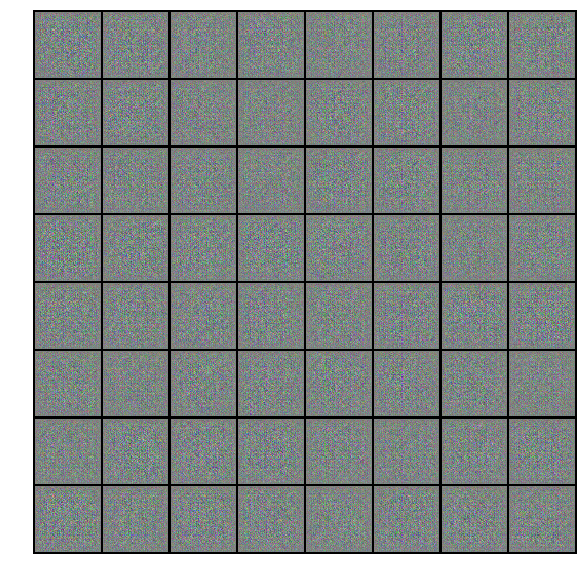

[0/1/125][1/2531] Loss_D: 0.2760 Loss_G: 1.4192 D(x): 0.7681 D(G(z)): 0.9364 / 0.2587
[0/1/125][2/2531] Loss_D: 0.6216 Loss_G: 1.6277 D(x): 0.5943 D(G(z)): 0.9514 / 0.2157
[0/1/125][3/2531] Loss_D: 1.0568 Loss_G: 2.4921 D(x): 0.4502 D(G(z)): 0.9124 / 0.0934
[0/1/125][4/2531] Loss_D: 0.9315 Loss_G: 3.1663 D(x): 0.4645 D(G(z)): 0.8817 / 0.0449
[0/1/125][5/2531] Loss_D: 1.1161 Loss_G: 4.0558 D(x): 0.4358 D(G(z)): 0.7410 / 0.0190
[0/1/125][6/2531] Loss_D: 1.0456 Loss_G: 4.4158 D(x): 0.4642 D(G(z)): 0.6658 / 0.0133
[0/1/125][7/2531] Loss_D: 0.9301 Loss_G: 4.7238 D(x): 0.5185 D(G(z)): 0.5645 / 0.0101
[0/1/125][8/2531] Loss_D: 0.9273 Loss_G: 5.0509 D(x): 0.5296 D(G(z)): 0.6518 / 0.0071
[0/1/125][9/2531] Loss_D: 0.7521 Loss_G: 5.4094 D(x): 0.5833 D(G(z)): 0.6218 / 0.0050
[0/1/125][10/2531] Loss_D: 1.0286 Loss_G: 5.7718 D(x): 0.5041 D(G(z)): 0.6583 / 0.0034
[0/1/125][11/2531] Loss_D: 0.6223 Loss_G: 5.8754 D(x): 0.6286 D(G(z)): 0.5375 / 0.0033
[0/1/125][12/2531] Loss_D: 1.0878 Loss_G: 5.9014 D(x

[0/1/125][96/2531] Loss_D: 0.9864 Loss_G: 1.2225 D(x): 0.4070 D(G(z)): 0.5836 / 0.3029
[0/1/125][97/2531] Loss_D: 0.9090 Loss_G: 1.1731 D(x): 0.4473 D(G(z)): 0.6222 / 0.3177
[0/1/125][98/2531] Loss_D: 0.9756 Loss_G: 1.3213 D(x): 0.4377 D(G(z)): 0.5804 / 0.2828
[0/1/125][99/2531] Loss_D: 0.9287 Loss_G: 1.5429 D(x): 0.4435 D(G(z)): 0.6128 / 0.2295
[0/1/125][100/2531] Loss_D: 0.9124 Loss_G: 1.5923 D(x): 0.4465 D(G(z)): 0.6440 / 0.2198


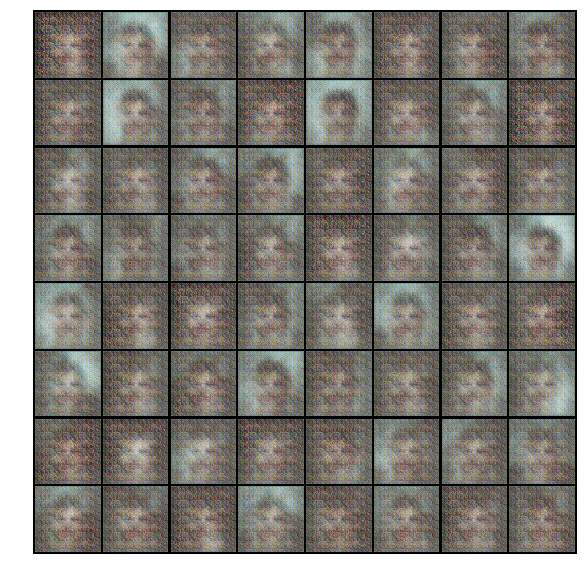

[0/1/125][101/2531] Loss_D: 1.0926 Loss_G: 1.4867 D(x): 0.4192 D(G(z)): 0.5797 / 0.2358
[0/1/125][102/2531] Loss_D: 0.9940 Loss_G: 1.3462 D(x): 0.4232 D(G(z)): 0.5600 / 0.2711
[0/1/125][103/2531] Loss_D: 0.9613 Loss_G: 1.3165 D(x): 0.4333 D(G(z)): 0.5568 / 0.2973
[0/1/125][104/2531] Loss_D: 0.8679 Loss_G: 1.1246 D(x): 0.4579 D(G(z)): 0.6692 / 0.3559
[0/1/125][105/2531] Loss_D: 0.9767 Loss_G: 1.1603 D(x): 0.4220 D(G(z)): 0.6196 / 0.3374
[0/1/125][106/2531] Loss_D: 0.8243 Loss_G: 1.2090 D(x): 0.4780 D(G(z)): 0.5853 / 0.3197
[0/1/125][107/2531] Loss_D: 0.9038 Loss_G: 1.2324 D(x): 0.4313 D(G(z)): 0.5938 / 0.3106
[0/1/125][108/2531] Loss_D: 0.9514 Loss_G: 1.2200 D(x): 0.4070 D(G(z)): 0.5492 / 0.3205
[0/1/125][109/2531] Loss_D: 0.7807 Loss_G: 1.1688 D(x): 0.4852 D(G(z)): 0.5308 / 0.3348
[0/1/125][110/2531] Loss_D: 0.8389 Loss_G: 1.1217 D(x): 0.4825 D(G(z)): 0.6087 / 0.3476
[0/1/125][111/2531] Loss_D: 0.9143 Loss_G: 1.2268 D(x): 0.4439 D(G(z)): 0.5510 / 0.3063
[0/1/125][112/2531] Loss_D: 0.92

[0/1/125][195/2531] Loss_D: 0.8585 Loss_G: 1.0610 D(x): 0.4364 D(G(z)): 0.4921 / 0.3559
[0/1/125][196/2531] Loss_D: 0.6738 Loss_G: 1.1500 D(x): 0.5295 D(G(z)): 0.5018 / 0.3341
[0/1/125][197/2531] Loss_D: 0.8652 Loss_G: 1.0491 D(x): 0.4397 D(G(z)): 0.4665 / 0.3674
[0/1/125][198/2531] Loss_D: 0.8015 Loss_G: 0.9505 D(x): 0.4644 D(G(z)): 0.4874 / 0.4110
[0/1/125][199/2531] Loss_D: 0.8210 Loss_G: 0.9492 D(x): 0.4586 D(G(z)): 0.5158 / 0.4076
[0/1/125][200/2531] Loss_D: 0.7728 Loss_G: 1.0473 D(x): 0.4881 D(G(z)): 0.4868 / 0.3753


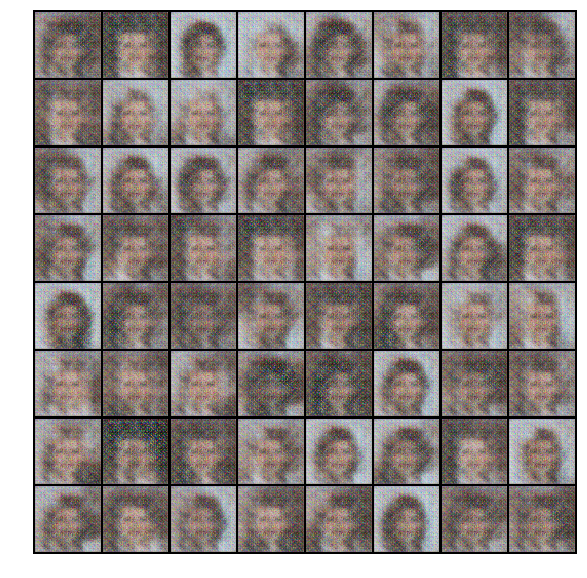

[0/1/125][201/2531] Loss_D: 0.8173 Loss_G: 0.9115 D(x): 0.4598 D(G(z)): 0.5256 / 0.4212
[0/1/125][202/2531] Loss_D: 0.8404 Loss_G: 0.9098 D(x): 0.4518 D(G(z)): 0.5220 / 0.4146
[0/1/125][203/2531] Loss_D: 0.7729 Loss_G: 0.9699 D(x): 0.4778 D(G(z)): 0.5717 / 0.3948
[0/1/125][204/2531] Loss_D: 0.8109 Loss_G: 1.0911 D(x): 0.4645 D(G(z)): 0.5128 / 0.3502
[0/1/125][205/2531] Loss_D: 0.8954 Loss_G: 1.0014 D(x): 0.4299 D(G(z)): 0.4748 / 0.3793
[0/1/125][206/2531] Loss_D: 0.8186 Loss_G: 0.9688 D(x): 0.4631 D(G(z)): 0.5106 / 0.3977
[0/1/125][207/2531] Loss_D: 0.7459 Loss_G: 1.0806 D(x): 0.4973 D(G(z)): 0.5652 / 0.3640
[0/1/125][208/2531] Loss_D: 0.7640 Loss_G: 1.0072 D(x): 0.4874 D(G(z)): 0.5180 / 0.3826
[0/1/125][209/2531] Loss_D: 0.6979 Loss_G: 1.1029 D(x): 0.5239 D(G(z)): 0.5280 / 0.3535
[0/1/125][210/2531] Loss_D: 0.8265 Loss_G: 1.0826 D(x): 0.4624 D(G(z)): 0.4893 / 0.3590
[0/1/125][211/2531] Loss_D: 0.8322 Loss_G: 0.9910 D(x): 0.4564 D(G(z)): 0.5031 / 0.4076
[0/1/125][212/2531] Loss_D: 0.81

In [ ]:
g_net.collect_params().zero_grad()
d_net.collect_params().zero_grad()
counter = 0
for epoch in range(opt.niter):
    for i, (d, _ ) in enumerate(train_data):
        # update D
        data = d.as_in_context(opt.ctx)
        label = nd.ones(opt.batchSize, opt.ctx)
        noise = mx.ndarray.normal(loc = 0, scale = 1, shape = (opt.batchSize, opt.nz,1,1),ctx = opt.ctx)
        with autograd.record():            
            output = d_net(data)
            D_error = nd.mean(binary_cross_entropy(output,label))
            D_x = nd.mean(output)
            fake_image = g_net(noise)
            output = d_net(fake_image.detach())
            D_error_fake_image = nd.mean(binary_cross_entropy(output,label*0))
            D_G_z1 = nd.mean(output)
            D_e = D_error + D_error_fake_image
            D_e.backward()
        D_trainer.step(opt.batchSize)       
        #update G
        label = nd.ones(opt.batchSize, opt.ctx)
        with autograd.record():
            fake_image = g_net(noise)
            output = d_net(fake_image)
            G_error = nd.mean(binary_cross_entropy(output,label))
            D_G_z2 = nd.mean(output)
            G_error.backward()
        G_trainer.step(opt.batchSize)
        
        
        print('[%d/%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch,counter, opt.niter, i, len(train_data),
                 D_error.asnumpy(), G_error.asnumpy(), D_x.asnumpy(), D_G_z1.asnumpy(), D_G_z2.asnumpy()))
        trunctate = 1
        if i % (100*trunctate) == 0:
            #image_show(data)
            image_show(fake_image)
        if i % (1000*trunctate) == 0:   
            plt.savefig('%s/%s/fake_samples_epoch_%03d.png' % (opt.outf,opt.dataset, epoch))
            filenameG = '%s/%s/G_Net_epoch_%d_%d' % (opt.outf, opt.dataset, epoch,counter)
            filenameD = '%s/%s/D_Net_epoch_%d_%d' % (opt.outf, opt.dataset, epoch,counter)
            g_net.save_params(filenameG)
            d_net.save_params(filenameD)
            counter = counter + 1
    counter = 0
